In [1]:
import os
import os.path as osp
import sys
import numpy as np
import torch, torchvision
from torch import nn
from torch.utils import model_zoo
from torch.nn.parallel import DataParallel
from torch.utils.data import DataLoader
from torch.utils.data.dataset import ConcatDataset
# %load_ext autoreload
# %autoreload 2

In [5]:
import sys
sys.path.append('/home/damon/detorch/')
from visualization_utils import *
from debug_utils import *

In [2]:
# Get cfg
import mmcv
config_file = 'visdrone/configs/ssd300.py'
cfg = mmcv.Config.fromfile(config_file)

In [3]:
# Get model
from mmdet.models import build_detector
model = build_detector(cfg.model, train_cfg=None, test_cfg=cfg.test_cfg)
# load from checkpoint
from mmcv.runner import load_checkpoint
checkpoint_file = 'work_dirs/ssd300_visdrone/latest.pth'
_ = load_checkpoint(model, checkpoint_file)

missing keys in source state_dict: extra.1.bias, extra.1.weight, extra.2.weight, extra.7.bias, extra.0.weight, extra.7.weight, extra.4.weight, extra.6.bias, extra.5.bias, l2_norm.weight, extra.4.bias, extra.6.weight, extra.0.bias, extra.5.weight, extra.3.weight, extra.2.bias, extra.3.bias



In [4]:
from mmdet.apis import inference_detector, show_result

# test a single image and show the results
img = '/tmp/visdrone-debug/images/0000001_02999_d_0000005.jpg'
result = inference_detector(model, img, cfg, device='cuda')
# result is list of np array with [N, 5]
# show_result(img, result, 'visdrone')

In [40]:
'{}.txt'.format('44')

'44.txt'

In [34]:
result_bboxes = []
for res in result:
    bbox = res[:, :4]
    x1, y1, x2, y2 = np.split(bbox, 4, 1)
    bbox = np.concatenate([y1, x1, y2, x2], 1)
    bbox = bbox[res[: , 4] > 0.1]
    result_bboxes.append(bbox)
result_bboxes = np.concatenate(result_bboxes, 0)
print(result_bboxes.shape)

(324, 4)


In [38]:
def write_result_into_txt(result, txt_file):
    with open(txt_file, 'w') as fid:
        for i, res in enumerate(result):
            cat_id = i + 1
            if len(res) == 0:
                continue
            for det in res:
                x1, y1, x2, y2, sc = det
                w = x2 - x1
                h = y2 - y1
                fid.writelines('%d,%d,%d,%d,%.4f,%d,-1,-1\n' % (
                    x1, y1, w, h, sc, cat_id
                ))

In [39]:
write_result_into_txt(result, '/tmp/fuck.txt')

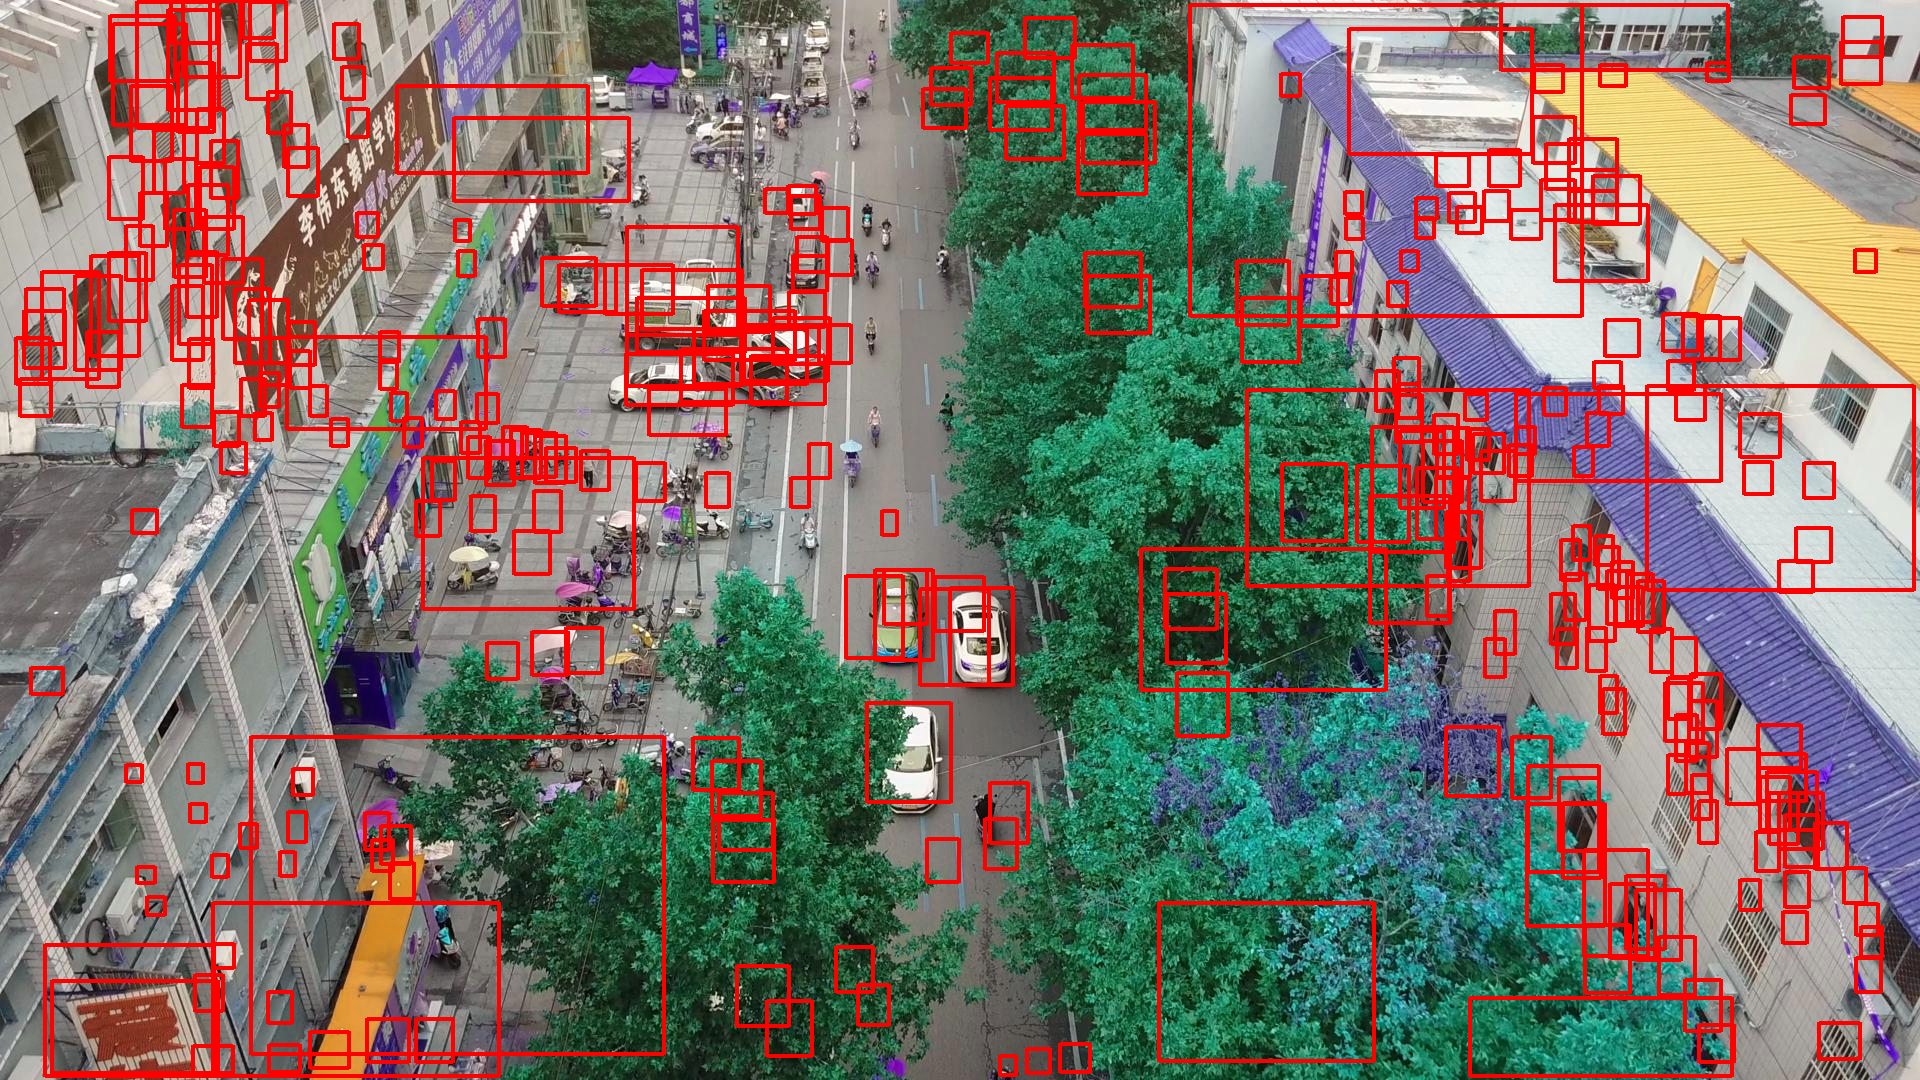

In [35]:
img_arr = mmcv.imread(img)
draw_bounding_boxes_on_image_array(img_arr, result_bboxes)
visualize_image_array(img_arr)

In [ ]:
# Conver json['annotations'] to boxes
def get_gt_boxes_from_img_name_COCO(json_ann, image_name):
    image_id = None
    for im in json_ann['images']:
        if im['file_name'] != image_name:
            continue
        else:
            image_id = im['id']
            break
    print(image_id)
    if image_id == None:
        raise ValueError("Not found")
    boxes = []
    for info in json_ann['annotations']:
        if info['image_id'] == image_id:
            x1, y1, w, h = info['bbox']
            bbox = [y1, x1, y1 + h, x1 + w]
            boxes.append(bbox)
    return np.asarray(boxes)